In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
!pip install wfdb
import wfdb
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_train/train_meta.csv')

if all(col in df.columns for col in ['age', 'height', 'weight', 'nurse', 'site', 'sex']):

    df_cleaned = df.dropna(subset=['age', 'height', 'weight', 'nurse', 'site', 'sex'])

    median_by_sex = df_cleaned.groupby('sex')[['age', 'height', 'weight']].median()
    print("Trung vị của age, height, weight theo giới tính:")
    display(median_by_sex)

    median_nurse_site = df_cleaned[['nurse', 'site']].median()
    print("\nTrung vị của nurse và site:")
    display(median_nurse_site)

else:
    print("Một số cột cần thiết không tồn tại trong dữ liệu.")

Trung vị của age, height, weight theo giới tính:


,age,height,weight
sex,,,
0,65.0,174.0,76.0
1,69.0,160.0,63.0



Trung vị của nurse và site:


,0
nurse,6.0
site,1.0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_train/train_meta.csv')
df = df.set_index('ecg_id')
median_by_sex = {
    0: {'age': 65.0, 'height': 174.0, 'weight': 76.0},
    1: {'age': 69.0, 'height': 160.0, 'weight': 63.0}
}
median_nurse_site = {'nurse': 6.0, 'site': 1.0}

df['nurse'] = df['nurse'].fillna(median_nurse_site['nurse'])
df['site'] = df['site'].fillna(median_nurse_site['site'])
df['age'] = df.groupby('sex')['age'].transform(lambda x: x.fillna(median_by_sex[x.name]['age']))
df['height'] = df.groupby('sex')['height'].transform(lambda x: x.fillna(median_by_sex[x.name]['height']))
df['weight'] = df.groupby('sex')['weight'].transform(lambda x: x.fillna(median_by_sex[x.name]['weight']))

display(df.head())

,age,sex,height,weight,nurse,site,device,NORM,MI,STTC,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,1,160.0,63.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
2,19.0,0,174.0,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,37.0,1,160.0,69.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,5
4,24.0,0,174.0,82.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
5,19.0,1,160.0,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
display(df.iloc[:, :20].head(50))

In [ ]:
columns_to_extract = ['age', 'sex', 'height', 'weight', 'nurse', 'site']
columns_to_extract2 = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
Y_train = df[columns_to_extract2]
display(Y_train.head())

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0


In [ ]:
df_signal = pd.read_csv('/content/drive/MyDrive/data_train/train_signal.csv')
display(df_signal.head())

,ecg_id,channel-0,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6,channel-7,channel-8,channel-9,channel-10,channel-11
0,1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,1,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,1,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,1,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


In [ ]:
display(df_signal.head(2000))

In [ ]:
print(df_signal.shape)

(17441000, 13)


In [ ]:
display(df_signal.head(50))

In [ ]:
df_signal_sorted = df_signal.sort_values(by=['ecg_id'])

In [ ]:
df_signal_sorted.shape

(17441000, 13)

In [ ]:
df_signal_sorted = df_signal_sorted.reset_index(drop=True)
display(df_signal_sorted.head(100))

,ecg_id,channel-0,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6,channel-7,channel-8,channel-9,channel-10,channel-11
0,1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,1,-0.053,-0.080,-0.027,0.067,-0.013,-0.053,0.001,-0.029,-0.002,-0.003,-0.031,-0.105
2,1,-0.030,-0.080,-0.050,0.055,0.010,-0.065,-0.001,-0.039,-0.007,-0.007,-0.030,-0.105
3,1,-0.021,-0.079,-0.059,0.050,0.019,-0.069,-0.005,-0.044,-0.015,-0.010,-0.031,-0.105
4,1,-0.032,-0.065,-0.033,0.049,0.001,-0.049,-0.010,-0.034,-0.018,-0.014,-0.025,-0.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0.011,-0.028,-0.039,0.008,0.025,-0.033,0.056,0.069,0.004,-0.011,-0.050,-0.081
96,1,0.004,-0.036,-0.041,0.016,0.023,-0.039,0.053,0.067,0.001,-0.027,-0.050,-0.074
97,1,-0.028,-0.069,-0.040,0.048,0.006,-0.054,0.068,0.076,-0.001,-0.033,-0.050,-0.068
98,1,-0.025,-0.062,-0.037,0.044,0.006,-0.049,0.088,0.106,0.001,-0.023,-0.049,-0.061


In [ ]:
df_signal_sorted1 = df_signal_sorted.set_index('ecg_id')
display(df_signal_sorted1.head(100))

,channel-0,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6,channel-7,channel-8,channel-9,channel-10,channel-11
ecg_id,,,,,,,,,,,,
1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,-0.053,-0.080,-0.027,0.067,-0.013,-0.053,0.001,-0.029,-0.002,-0.003,-0.031,-0.105
1,-0.030,-0.080,-0.050,0.055,0.010,-0.065,-0.001,-0.039,-0.007,-0.007,-0.030,-0.105
1,-0.021,-0.079,-0.059,0.050,0.019,-0.069,-0.005,-0.044,-0.015,-0.010,-0.031,-0.105
1,-0.032,-0.065,-0.033,0.049,0.001,-0.049,-0.010,-0.034,-0.018,-0.014,-0.025,-0.101
...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.011,-0.028,-0.039,0.008,0.025,-0.033,0.056,0.069,0.004,-0.011,-0.050,-0.081
1,0.004,-0.036,-0.041,0.016,0.023,-0.039,0.053,0.067,0.001,-0.027,-0.050,-0.074
1,-0.028,-0.069,-0.040,0.048,0.006,-0.054,0.068,0.076,-0.001,-0.033,-0.050,-0.068


In [ ]:
df_signal_sorted.shape

(17441000, 13)

In [ ]:
signal_array = df_signal_sorted.iloc[:, 1:].values

In [ ]:
signal_array.shape

(17441000, 12)

In [ ]:
signal_segments = signal_array.reshape((17441, 1000, 12))
print(signal_segments.shape)

(17441, 1000, 12)


In [ ]:
#df_ = pd.read_csv('/content/drive/MyDrive/data_train/train_meta.csv') #numpy
y_labels = df_[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
assert signal_segments.shape[0] == y_labels.shape[0]
print(y_labels.shape)

(17441, 5)


In [ ]:
X_train = signal_segments
#Y_train = y_labels

In [ ]:
X_train.shape

(17441, 1000, 12)

In [ ]:
Y_train.shape

(17441, 5)

In [ ]:
import numpy as np


indices = [0, 1, 2, 3, 4]
vc = Y_train[:, indices].sum(axis=0)


percentages = vc / Y_train.shape[0] * 100
print(percentages)


[43.61561837 25.16484147 24.04105269 22.42990654 12.16099994]


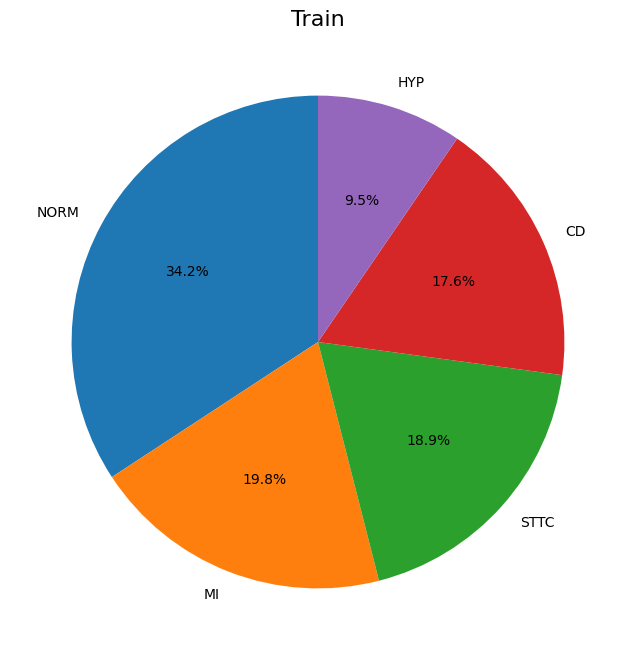

In [ ]:
import matplotlib.pyplot as plt

percentages
labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)

#plt.title("Diagnostic Superclass Distribution", fontsize=16)
plt.title("Train", fontsize=16)

plt.show()

In [ ]:
display(df.iloc[:, :20].head(50))

In [ ]:
df = df[['NORM', 'MI', 'STTC', 'CD', 'HYP']]
df
Y_train = df

In [ ]:
df_signal = pd.read_csv('/content/drive/MyDrive/data_train/test_signal.csv')
df_signal.shape

(2203000, 13)

In [ ]:
df_signal_sorted = df_signal.sort_values(by=['ecg_id']).reset_index(drop=True)
signal_array = df_signal_sorted.iloc[:, 1:].values
signal_segments = signal_array.reshape((2203, 1000, 12))
print(signal_segments.shape)

(2203, 1000, 12)


In [ ]:
df_meta = pd.read_csv('/content/drive/MyDrive/data_train/test_meta.csv')
y_labels = df_meta[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
assert signal_segments.shape[0] == y_labels.shape[0]
print(y_labels.shape)

(2203, 5)


In [ ]:
X_test = signal_segments
Y_test = y_labels

In [ ]:
import numpy as np


indices = [0, 1, 2, 3, 4]
vc = Y_test[:, indices].sum(axis=0)


percentages = vc / Y_test.shape[0] * 100
print(percentages)

[43.75851112 25.10213345 23.74035406 22.6055379  11.938266  ]


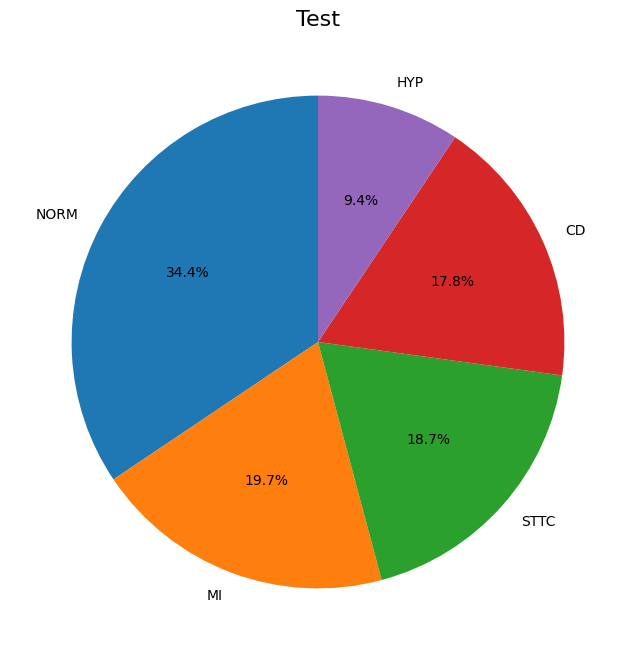

In [ ]:
import matplotlib.pyplot as plt

percentages = [43.75851112, 25.10213345, 23.74035406, 22.6055379,  11.938266  ]
labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)

#plt.title("Diagnostic Superclass Distribution", fontsize=16)
plt.title("Test", fontsize=16)
plt.show()


In [ ]:
display(df.iloc[:, :20].head(50))

In [ ]:
df_signal = pd.read_csv('/content/drive/MyDrive/data_train/valid_signal.csv')
df_signal.shape

In [ ]:
df_signal_sorted = df_signal.sort_values(by=['ecg_id']).reset_index(drop=True)
signal_array = df_signal_sorted.iloc[:, 1:].values
signal_segments = signal_array.reshape((2193, 1000, 12))
print(signal_segments.shape)

(2193, 1000, 12)


In [ ]:
df_meta = pd.read_csv('/content/drive/MyDrive/data_train/valid_meta.csv')
y_labels = df_meta[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
assert signal_segments.shape[0] == y_labels.shape[0]
print(y_labels.shape)

(2193, 5)


In [ ]:
X_valid = signal_segments
Y_valid = y_labels

In [ ]:
import numpy as np


indices = [0, 1, 2, 3, 4]
vc = Y_valid[:, indices].sum(axis=0)


percentages = vc / Y_valid.shape[0] * 100
print(percentages)

[43.63885089 24.80620155 24.3502052  22.6630187  12.35750114]


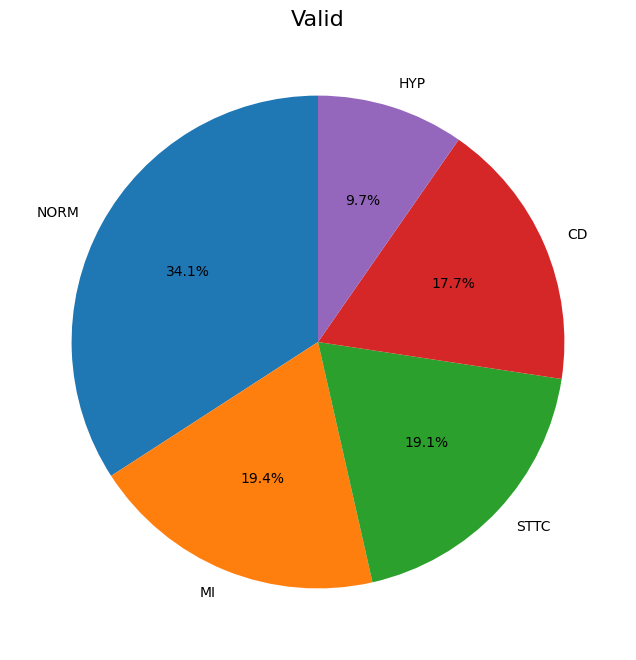

In [ ]:
import matplotlib.pyplot as plt

percentages
labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)

#plt.title("Diagnostic Superclass Distribution", fontsize=16)
plt.title("Valid", fontsize=16)
plt.show()


In [ ]:
display(df.iloc[:, :20].head(50))

In [ ]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_valid.shape, Y_valid.shape)

(17441, 1000, 12) (17441, 5) (2203, 1000, 12) (2203, 5) (2193, 1000, 12) (2193, 5)


In [ ]:
y_train = np.argmax(Y_train.iloc[:, :].values, axis=1)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# (NORM, MI, STTC, CD, HYP)
classes = np.array([0, 1, 2, 3, 4])

# Tính trọng số lớp
weights = compute_class_weight('balanced', classes=classes, y=y_train)

print("Trọng số lớp:", weights)


Trọng số lớp: [0.43948595 0.79494075 1.12088689 2.1965995  8.38509615]


In [ ]:
class_weights = dict(enumerate(weights))
print("Trọng số lớp:", class_weights)


Trọng số lớp: {0: 0.439485951870984, 1: 0.7949407474931631, 2: 1.1208868894601542, 3: 2.1965994962216624, 4: 8.385096153846154}


In [ ]:
Y_train_ = np.argmax(Y_train, axis=1)
Y_valid_ = np.argmax(Y_valid, axis=1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1000, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, Y_train_, epochs=30, batch_size=128, validation_data=(X_valid, Y_valid_), callbacks=[ reduce_lr], class_weight=class_weights)

Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.2105 - loss: 1.6637 - val_accuracy: 0.2622 - val_loss: 1.5813 - learning_rate: 0.0010
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2112 - loss: 1.5989 - val_accuracy: 0.3329 - val_loss: 1.4767 - learning_rate: 0.0010
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3107 - loss: 1.4527 - val_accuracy: 0.4095 - val_loss: 1.3987 - learning_rate: 0.0010
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.3441 - loss: 1.3466 - val_accuracy: 0.5718 - val_loss: 1.2135 - learning_rate: 0.0010
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4728 - loss: 1.2657 - val_accuracy: 0.6288 - val_loss: 1.0584 - learning_rate: 0.0010
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5320 - loss: 1.1792 - val_accuracy: 0.6119 - val_loss: 1.0338 - learning_rate: 0.0010
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5310 - los

In [ ]:
Y_test_ = np.argmax(Y_test, axis=1)
loss, accuracy = model.evaluate(X_test, Y_test_)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7230 - loss: 0.8001
Test Loss: 0.8016284704208374
Test Accuracy: 0.7199273705482483


In [ ]:
df_meta = pd.read_csv('/content/drive/MyDrive/data_train/test_meta.csv')
y_labels = df_meta[['NORM', 'MI', 'STTC', 'CD', 'HYP']]
label_counts = y_labels.sum(axis=0)
print(label_counts)

NORM    964
MI      553
STTC    523
CD      498
HYP     263
dtype: int64


In [ ]:
df_meta.shape

(2203, 37)

In [ ]:
df_meta[['NORM', 'MI', 'STTC', 'CD', 'HYP']].head(50)

,NORM,MI,STTC,CD,HYP
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,0,1,0,0,0
6,0,0,0,1,0
7,1,0,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LeakyReLU, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='leaky_relu', input_shape=(1000, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(64, activation=LeakyReLU()))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, Y_train_, epochs=30, batch_size=128, validation_data=(X_valid, Y_valid_), callbacks=[ reduce_lr], class_weight=class_weights)

Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.2482 - loss: 1.5700 - val_accuracy: 0.5381 - val_loss: 1.2507 - learning_rate: 0.0010
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5402 - loss: 1.2051 - val_accuracy: 0.4834 - val_loss: 1.2961 - learning_rate: 0.0010
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5760 - loss: 1.1070 - val_accuracy: 0.6101 - val_loss: 1.0559 - learning_rate: 0.0010
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6060 - loss: 1.0307 - val_accuracy: 0.5864 - val_loss: 1.0689 - learning_rate: 0.0010
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6186 - loss: 0.9760 - val_accuracy: 0.5850 - val_loss: 1.0427 - learning_rate: 0.0010
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6304 - loss: 0.9507 - val_accuracy: 0.6530 - val_loss: 0.9357 - learning_rate: 0.0010
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6527 - loss: 0.9044 

In [ ]:
Y_test_ = np.argmax(Y_test, axis=1)
loss, accuracy = model.evaluate(X_test, Y_test_)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6699 - loss: 0.8581
Test Loss: 0.8492021560668945
Test Accuracy: 0.6754425764083862


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


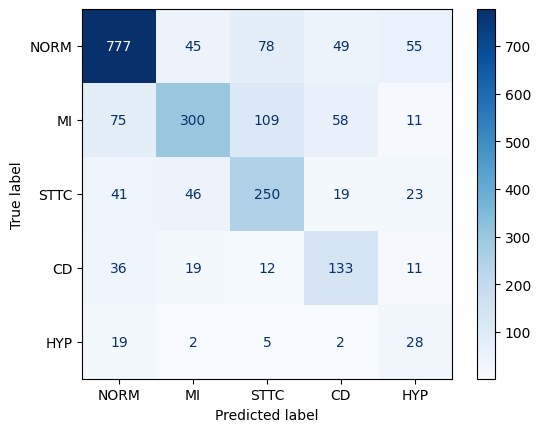

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(Y_test_, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
disp.plot(cmap="Blues")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LeakyReLU, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu', input_shape=(1000, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.6))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.6))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(128, activation=LeakyReLU()))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, Y_train_, epochs=30, batch_size=42, validation_data=(X_valid, Y_valid_), callbacks=[ reduce_lr], class_weight=class_weights)

Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.2505 - loss: 1.5463 - val_accuracy: 0.5887 - val_loss: 1.1347 - learning_rate: 0.0010
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5018 - loss: 1.2535 - val_accuracy: 0.6078 - val_loss: 1.0132 - learning_rate: 0.0010
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5392 - loss: 1.1420 - val_accuracy: 0.6398 - val_loss: 0.9576 - learning_rate: 0.0010
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5627 - loss: 1.0993 - val_accuracy: 0.6407 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5748 - loss: 1.0816 - val_accuracy: 0.6484 - val_loss: 0.9272 - learning_rate: 0.0010
Epoch 6/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6066 - loss: 0.9956 - val_accuracy: 0.6594 - val_loss: 0.9148 - learning_rate: 0.0010
Epoch 7/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6184 - loss: 0.9

In [ ]:
Y_test_ = np.argmax(Y_test, axis=1)
loss, accuracy = model.evaluate(X_test, Y_test_)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7342 - loss: 0.7733
Test Loss: 0.7694311738014221
Test Accuracy: 0.728551983833313


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


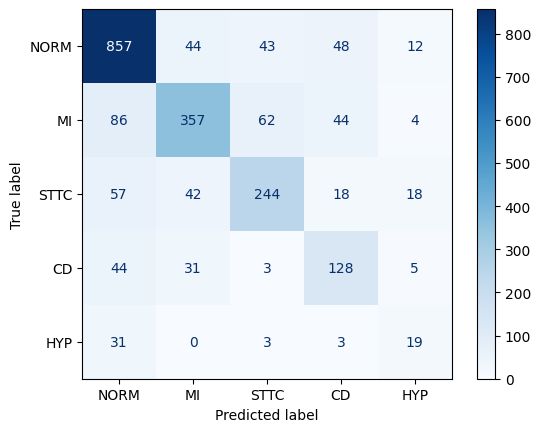

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(Y_test_, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
disp.plot(cmap="Blues")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LeakyReLU, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu', input_shape=(1000, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU()))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, Y_train_, epochs=50, batch_size=42, validation_data=(X_valid, Y_valid_), callbacks=[ reduce_lr], class_weight=class_weights)

Epoch 1/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.2711 - loss: 1.5454 - val_accuracy: 0.5636 - val_loss: 1.1045 - learning_rate: 0.0010
Epoch 2/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4927 - loss: 1.2333 - val_accuracy: 0.6243 - val_loss: 1.0367 - learning_rate: 0.0010
Epoch 3/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5459 - loss: 1.1794 - val_accuracy: 0.6461 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 4/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5749 - loss: 1.0616 - val_accuracy: 0.6110 - val_loss: 1.0465 - learning_rate: 0.0010
Epoch 5/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5941 - loss: 1.0310 - val_accuracy: 0.6617 - val_loss: 0.8949 - learning_rate: 0.0010
Epoch 6/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5900 - loss: 1.0150 - val_accuracy: 0.6585 - val_loss: 0.9373 - learning_rate: 0.0010
Epoch 7/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6244 - loss: 0.9

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LeakyReLU, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu', input_shape=(1000, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU()))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, Y_train_, epochs=50, batch_size=42, validation_data=(X_valid, Y_valid_), callbacks=[ reduce_lr], class_weight=class_weights)

Epoch 1/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.2464 - loss: 1.6134 - val_accuracy: 0.5518 - val_loss: 1.1723 - learning_rate: 0.0010
Epoch 2/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.4568 - loss: 1.3464 - val_accuracy: 0.6110 - val_loss: 1.0101 - learning_rate: 0.0010
Epoch 3/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5183 - loss: 1.2133 - val_accuracy: 0.5700 - val_loss: 1.1044 - learning_rate: 0.0010
Epoch 4/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5512 - loss: 1.1043 - val_accuracy: 0.6256 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 5/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5594 - loss: 1.0785 - val_accuracy: 0.6156 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 6/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5448 - loss: 1.1127 - val_accuracy: 0.6288 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 7/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5926 - loss: 

In [ ]:
model_path = '/content/drive/MyDrive/model.h5'
model.save(model_path)

In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/model.h5'

In [ ]:
#!pip install --upgrade tensorflow
from tensorflow.keras.models import load_model
from keras.layers import LeakyReLU

from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/model.h5'
model = load_model(model_path, custom_objects={'LeakyReLU': LeakyReLU})

print("Mô hình đã được tải thành công!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mô hình đã được tải thành công!


In [ ]:
Y_test_ = np.argmax(Y_test, axis=1)
loss, accuracy = model.evaluate(X_test, Y_test_)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7230 - loss: 0.8001
Test Loss: 0.8016284704208374
Test Accuracy: 0.7199273705482483


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


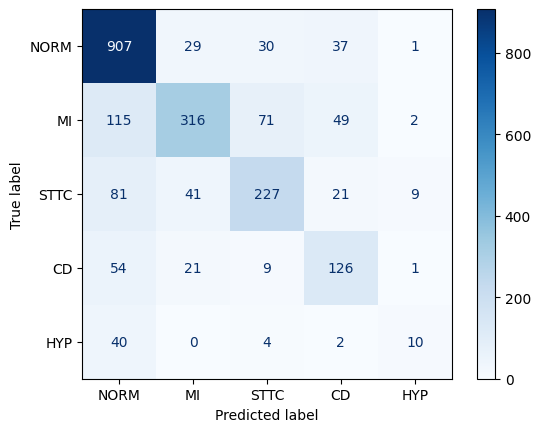

In [ ]:
#model.summary()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(Y_test_, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
disp.plot(cmap="Blues")

In [ ]:
Y_test_ = np.argmax(Y_test, axis=1)
loss, accuracy = model.evaluate(X_test, Y_test_)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7230 - loss: 0.8001
Test Loss: 0.8016284108161926
Test Accuracy: 0.7199273705482483


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

y_pred_df = pd.DataFrame(y_pred_classes, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
print(y_pred_df.head(50))


69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step
    NORM  MI  STTC  CD  HYP
0      1   0     0   0    0
1      1   0     0   0    0
2      1   0     0   0    0
3      1   0     0   0    0
4      1   0     0   0    0
5      1   0     0   0    0
6      1   0     0   0    0
7      1   0     0   0    0
8      1   0     0   0    0
9      1   0     0   0    0
10     1   0     0   0    0
11     1   0     0   0    0
12     1   0     0   0    0
13     1   0     0   0    0
14     0   0     1   0    0
15     1   0     0   0    0
16     1   0     0   0    0
17     1   0     0   0    0
18     1   0     0   0    0
19     1   0     0   0    0
20     1   0     0   0    0
21     1   0     0   0    0
22     0   0     0   1    0
23     0   0     0   0    0
24     0   1     0   0    0
25     1   0     0   0    0
26     0   0     0   1    0
27     1   0     0   0    0
28     0   0     0   1    0
29     1   0     0   0    0
30     1   0     0   0    0
31     1   0     0   0    0
32     0   0     0   0    0
33     1